In [1]:
%pip install --upgrade numpy tensorflow pandas matplotlib

  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd

In [3]:
# Cargamos los datos
(x_train, y_train) , (x_test, y_test) = keras.datasets.mnist.load_data()

train_morpho = pd.read_csv("train-morpho.csv")
test_morpho = pd.read_csv("t10k-morpho.csv")

In [4]:
train_morpho

,index,area,length,thickness,slant,width,height
0,0,107.3125,50.266504,2.460658,0.231074,14.539572,19.849054
1,1,123.2500,51.198485,2.616601,0.331858,15.387810,19.341053
2,2,78.3750,45.927670,1.891592,-0.212196,20.479656,19.114880
3,3,67.3125,22.849242,2.919769,0.509185,5.358179,19.724599
4,4,91.1875,46.284271,2.247425,0.007590,13.275437,19.527523
...,...,...,...,...,...,...,...
59995,59995,102.1875,61.415999,1.941380,0.366472,11.840672,19.937599
59996,59996,108.5625,46.705844,2.538071,0.364359,13.325950,19.688557
59997,59997,87.0625,44.523864,2.058077,0.257784,14.133500,20.070647
59998,59998,82.2500,53.337572,1.667193,0.310377,15.251961,19.692976


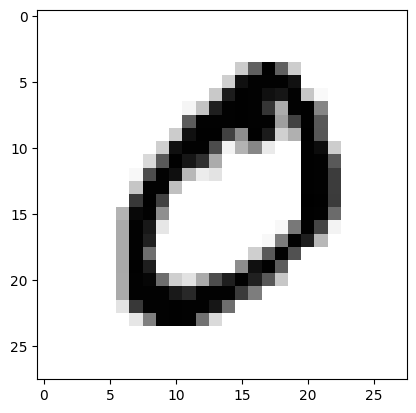

In [5]:
plt.imshow(x_train[1], cmap=plt.cm.binary)
plt.show()

# Veamos algunas imágenes de cada clase

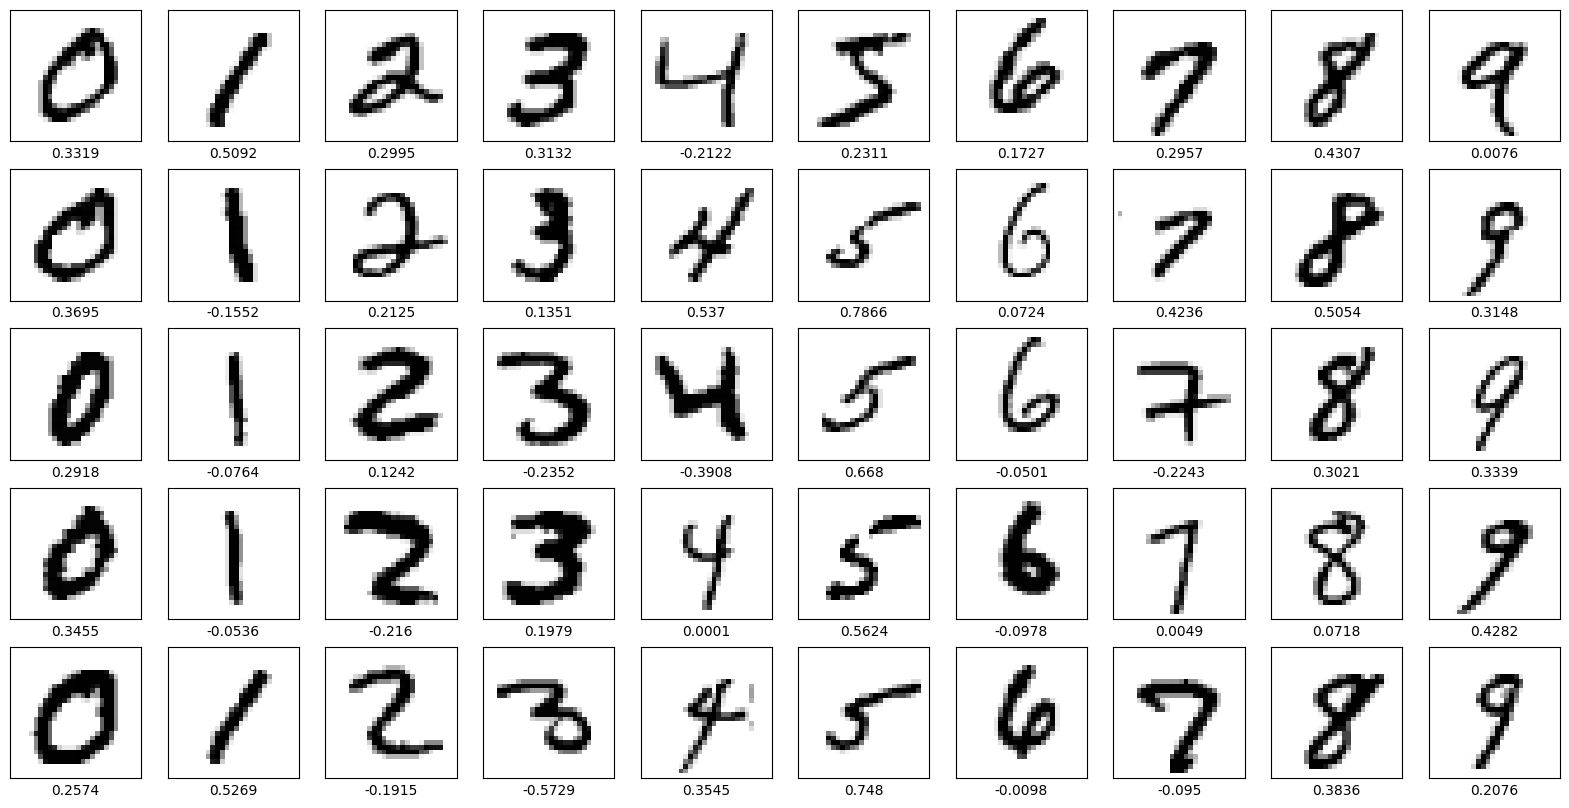

In [6]:
# Muestra las primeras 5 imágenes de cada clase con su inclinacion
plt.figure(figsize=(20,10))
for i in range(10):
  for j in range(5):
    plt.subplot(5,10,1+i+10*j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[y_train == i][j], cmap=plt.cm.binary)
    plt.xlabel(round(train_morpho[y_train == i].iloc[j]['slant'],4))
plt.show()

Cómo es el promedio de las imagenes y sus inclinaciones?

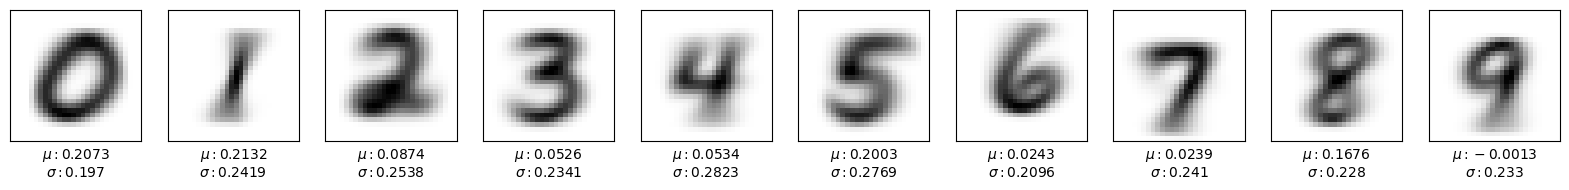

In [7]:
# Muestra el promedio de las clases y su inclinacion promedio y desvio estandar
plt.figure(figsize=(20,10))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.mean(x_train[y_train == i], axis=0), cmap=plt.cm.binary)
  plt.xlabel('$\mu: ' + str(round(train_morpho[y_train == i]['slant'].mean(), 4)) + '$\n$\sigma: ' + str(round(train_morpho[y_train == i]['slant'].std(), 4)) + '$')
plt.show()

### Como están distribuidos los datos?

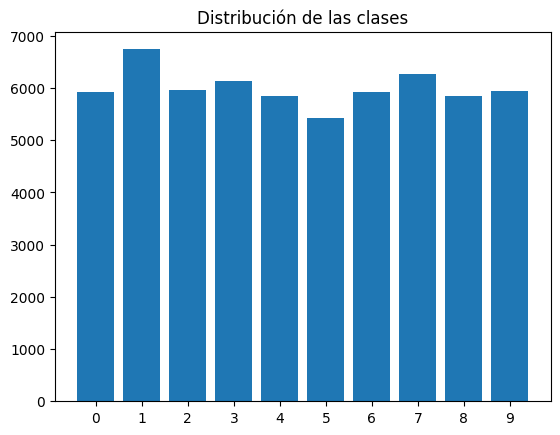

In [8]:
h, b = np.histogram(y_train, range=(0,10))
plt.bar(range(len(h)), h, tick_label=range(10))
plt.title("Distribución de las clases")
plt.show()

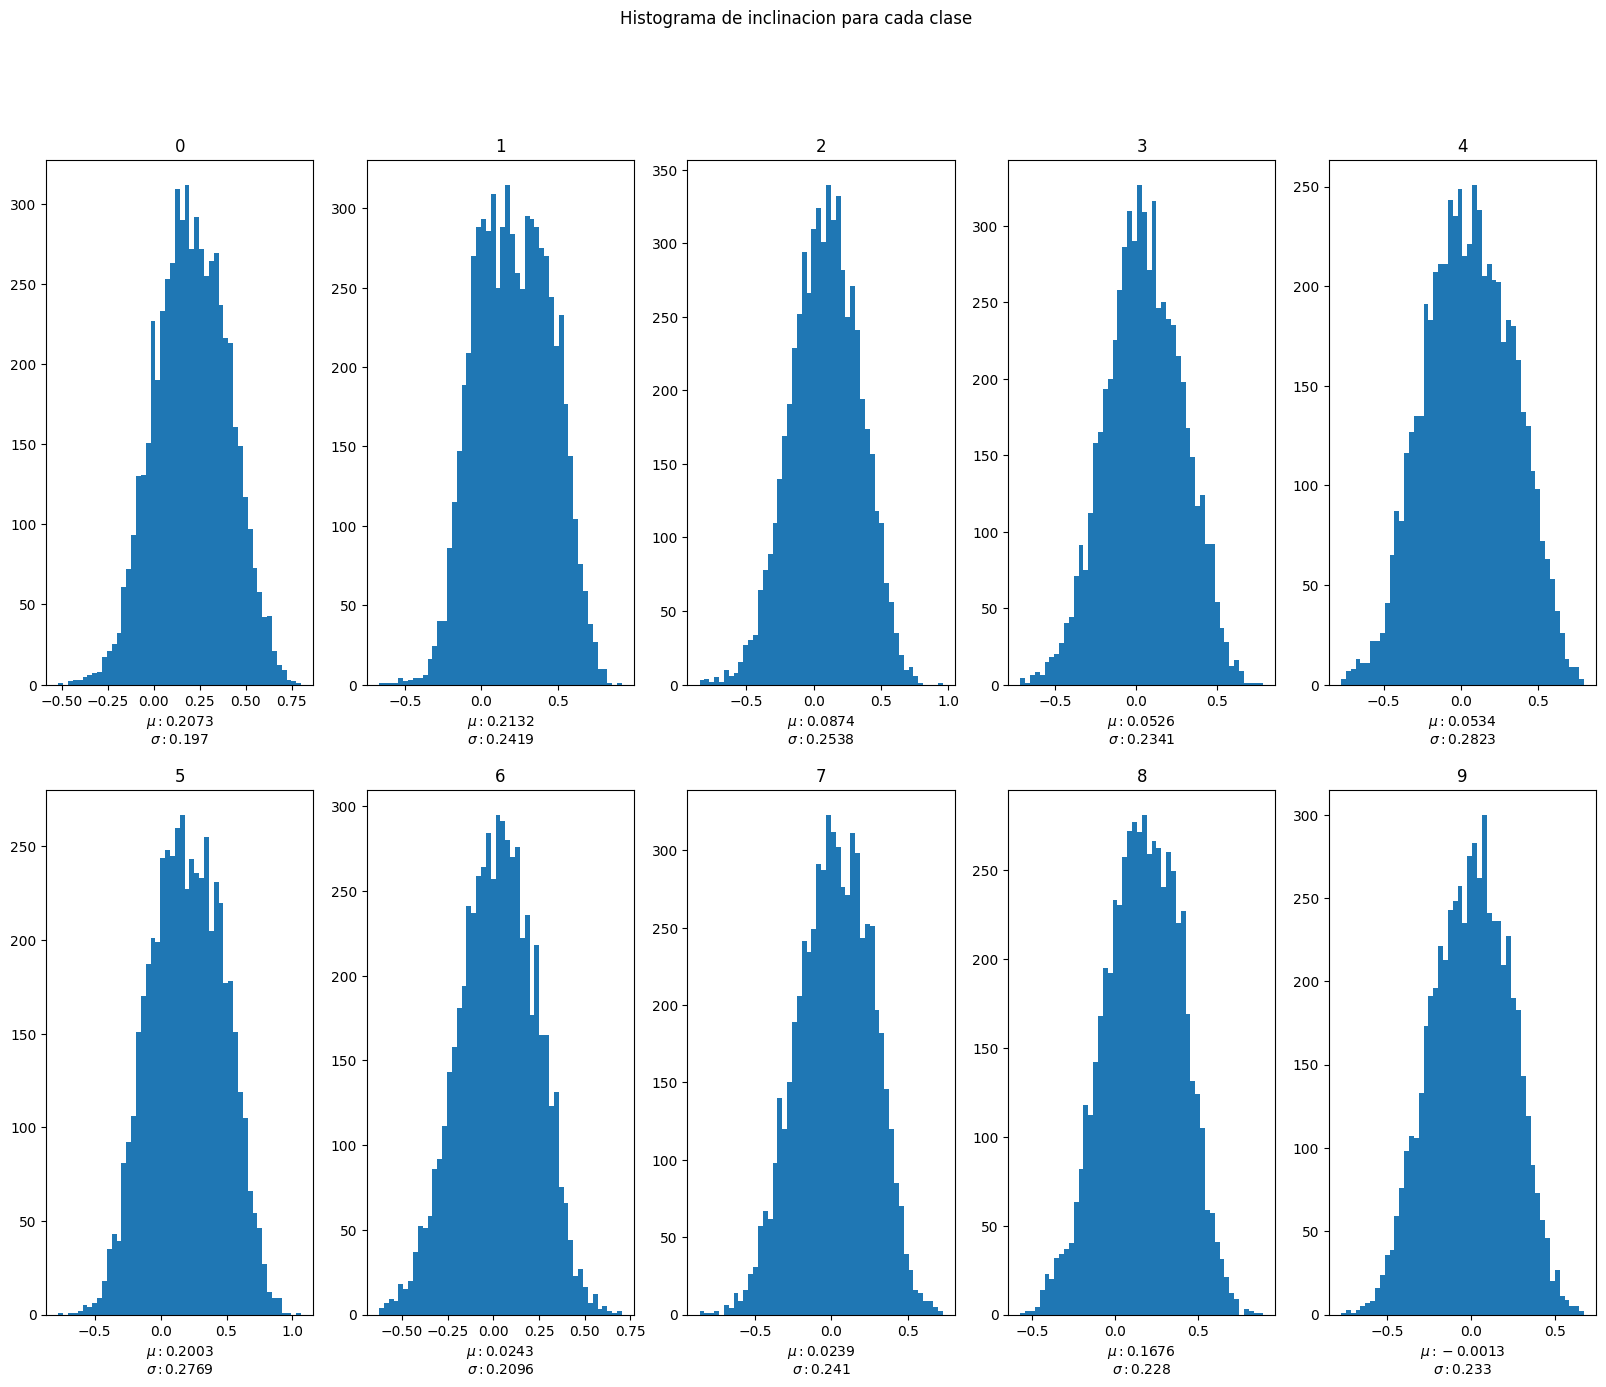

In [9]:
# Histograma de inclinacion para cada clase
plt.figure(figsize=(20,15))
plt.suptitle("Histograma de inclinacion para cada clase")
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.title(i)
  plt.hist(train_morpho['slant'][y_train==i], bins=50)
  plt.xlabel('$\mu: ' + str(round(train_morpho[y_train == i]['slant'].mean(), 4)) + '$\n$\sigma: ' + str(round(train_morpho[y_train == i]['slant'].std(), 4)) + '$')
plt.show()

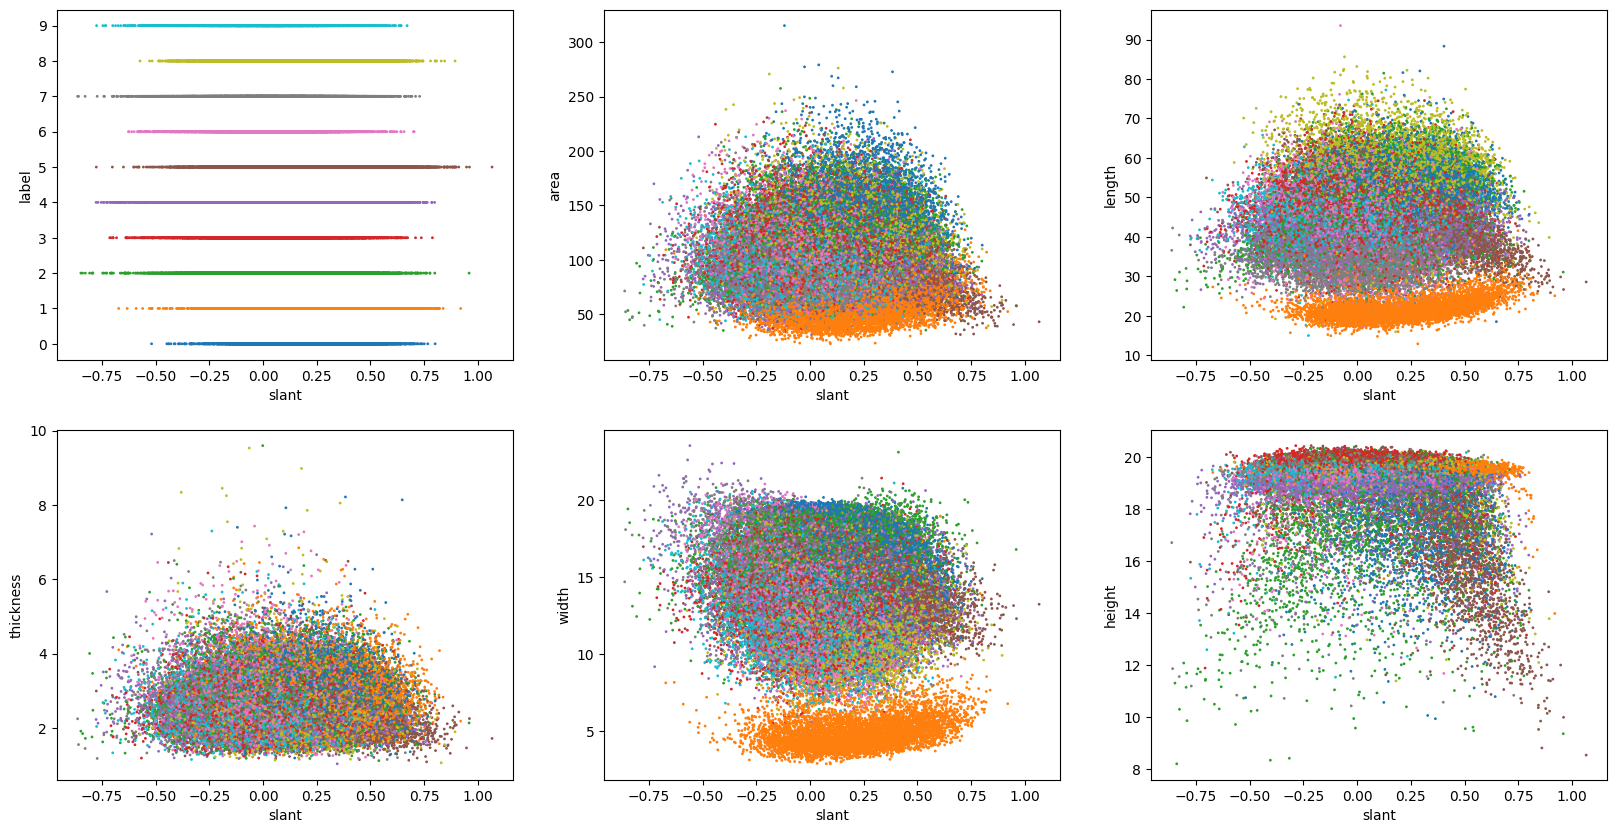

In [88]:
values = train_morpho.columns[~np.isin(train_morpho.columns, ['index', 'slant'])]

colors = [f'C{n}' for n in y_train]

plt.figure(figsize=(20,10))

plt.subplot(2, len(values)//2+1, 1)
plt.xlabel('slant')
plt.ylabel('label')
plt.scatter(train_morpho['slant'], y_train, s=1., c=colors)
plt.yticks(range(10))

for i, v in enumerate(values):
  plt.subplot(2, len(values)//2+1, i+2)
  plt.xlabel('slant')
  plt.ylabel(v)
  plt.scatter(train_morpho['slant'], train_morpho[v], s=1, c=colors)


plt.show()

No pareciera haber gran correlación entre la inclinación y los otros valores, salvo quizás para la altura, donde se puede ver una pequeña tendencia a bajar cuando hay inclinación

## Data augmentation

Idea: Algunos numeros: (0, 1, 8) se pueden espejar y por lo tanto, se le cambia el signo a la inclinaacion

In [11]:
newXData = x_train[np.isin(y_train, [0,1,8]),:,::-1] # Espejamos en el eje vertical
newYData = y_train[np.isin(y_train, [0,1,8])]
newMorpho = train_morpho[np.isin(y_train, [0, 1, 8])].copy()
newMorpho['slant'] *= -1

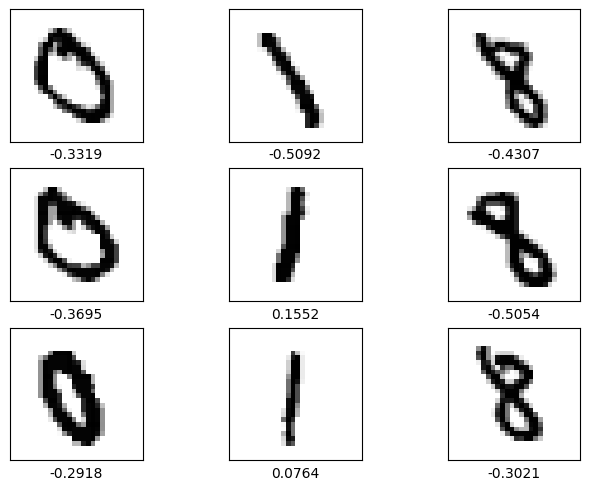

In [12]:
# Muestra las primeras 3 imágenes de cada clase con su inclinacion
plt.figure(figsize=(8,10))
for count, i in enumerate((0, 1, 8)):
  plt.subplot(5,3,i+1)
  for j in (range(3)):
    plt.subplot(5,3,1+count+3*j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(newXData[newYData == i][j], cmap=plt.cm.binary)
    plt.xlabel(round(newMorpho[newYData == i].iloc[j]['slant'],4))
plt.show()

In [13]:
x_data = np.append(x_train, newXData, axis=0)
y_data = np.append(y_train, newYData, axis=0)
morpho = pd.concat([train_morpho, newMorpho])
morpho['label'] = y_data        # Agrego el label al morpho
print(len(x_data), len(y_data), len(morpho))

78516 78516 78516


## Preprocesamiento

In [14]:
x_data = x_data / 255.0
x_test = x_test / 255.0

In [15]:
from sklearn.model_selection import train_test_split

xTrain, xVal, morphoTrain, morphoVal = train_test_split(x_data, morpho, random_state=99, train_size = .8)
yTrain = morphoTrain['slant']
yVal = morphoVal['slant']

In [16]:
# Metricas de interes
metrics = ['mae', 'mse']

In [17]:
# Early stop
earlyCb = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True, verbose=1)

## Modelo base

Partimos del siguiente modelo

In [18]:
modelBase = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(1),
])

In [19]:
modelBase.compile(optimizer='adam',
              loss='mae',
              metrics=metrics)
modelBase.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [20]:
fited = modelBase.fit(xTrain, yTrain, batch_size=256, epochs=1000, validation_data=(xVal, yVal),
                      callbacks=[earlyCb])

Epoch 1/1000
246/246 [==============================] - 1s 3ms/step - loss: 0.0585 - mae: 0.0585 - mse: 0.0079 - val_loss: 0.0363 - val_mae: 0.0363 - val_mse: 0.0032
Epoch 2/1000
246/246 [==============================] - 1s 3ms/step - loss: 0.0308 - mae: 0.0308 - mse: 0.0023 - val_loss: 0.0227 - val_mae: 0.0227 - val_mse: 0.0014
Epoch 3/1000
246/246 [==============================] - 1s 3ms/step - loss: 0.0240 - mae: 0.0240 - mse: 0.0013 - val_loss: 0.0270 - val_mae: 0.0270 - val_mse: 0.0013
Epoch 4/1000
246/246 [==============================] - 1s 3ms/step - loss: 0.0183 - mae: 0.0183 - mse: 8.1168e-04 - val_loss: 0.0151 - val_mae: 0.0151 - val_mse: 6.3019e-04
Epoch 5/1000
246/246 [==============================] - 1s 3ms/step - loss: 0.0201 - mae: 0.0201 - mse: 8.3965e-04 - val_loss: 0.0149 - val_mae: 0.0149 - val_mse: 5.4437e-04
Epoch 6/1000
246/246 [==============================] - 1s 3ms/step - loss: 0.0167 - mae: 0.0167 - mse: 6.1199e-04 - val_loss: 0.0138 - val_mae: 0.0138 - 

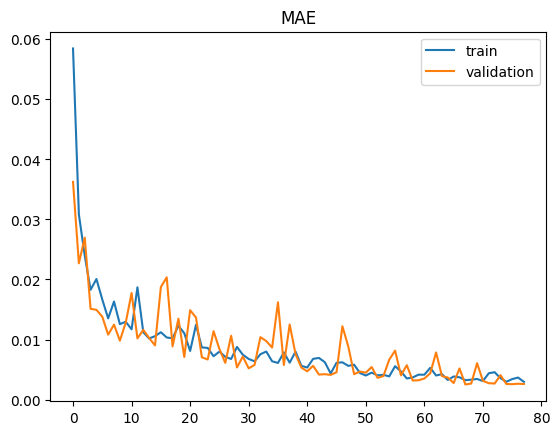

In [21]:
plt.title("MAE")
plt.plot(fited.history['mae'], label='train')
plt.plot(fited.history['val_mae'], label='validation')
plt.legend()
plt.show()

Se ve un poco ruidoso, pero lo iremos mejorando. Buena correlación entre train y validacion

# Pruebas

### Cambiando el modelo

In [117]:
activations = ['sigmoid', 'relu', 'tanh', 'elu']
optimizers = ['adam', 'adamax', 'rmsprop', 'sgd']
losses = ['mae', 'mse']

Cambio cantidad de capas, unidades, activacion, loss y optimizador

In [123]:
import keras_tuner as kt

def build_MNIST_model(hp):

    units = hp.Choice('units', [64, 128, 256])
    activation = hp.Choice('activation', activations)

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) 
    
    for i in range(hp.Int("n_layers", min_value=1, max_value=5)):
        model.add(keras.layers.Dense(units=units, activation=activation))
    
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', optimizers),
        loss=hp.Choice('loss', losses),
        metrics=metrics,
    )
    return model

Son 480 modelos

In [124]:
tuner = kt.GridSearch(build_MNIST_model, objective='val_mae', project_name='tuner_project2', overwrite=False)
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu', 'tanh', 'elu'], 'ordered': False}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adamax', 'rmsprop', 'sgd'], 'ordered': False}
loss (Choice)
{'default': 'mae', 'conditions': [], 'values': ['mae', 'mse'], 'ordered': False}


In [125]:
tuner.search(xTrain, yTrain, batch_size=256, epochs=200, validation_data=(xVal, yVal), callbacks=[earlyCb])

Trial 388 Complete [00h 03m 22s]
val_mae: 0.003269062377512455

Best val_mae So Far: 0.0014380725333467126
Total elapsed time: 08h 12m 59s

Search: Running Trial #389

Value             |Best Value So Far |Hyperparameter
256               |64                |units
relu              |sigmoid           |activation
4                 |3                 |n_layers
rmsprop           |adam              |optimizer
mae               |mse               |loss

Epoch 1/200
246/246 [==============================] - 3s 8ms/step - loss: 0.0744 - mae: 0.0744 - mse: 0.0183 - val_loss: 0.0363 - val_mae: 0.0363 - val_mse: 0.0024
Epoch 2/200
246/246 [==============================] - 2s 7ms/step - loss: 0.0382 - mae: 0.0382 - mse: 0.0025 - val_loss: 0.0248 - val_mae: 0.0248 - val_mse: 0.0011
Epoch 3/200
246/246 [==============================] - 2s 7ms/step - loss: 0.0307 - mae: 0.0307 - mse: 0.0016 - val_loss: 0.0387 - val_mae: 0.0387 - val_mse: 0.0026
Epoch 4/200
246/246 [==============================]

KeyboardInterrupt: 

In [126]:
tuner.results_summary()

Results summary
Results in .\tuner_project2
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0017 summary
Hyperparameters:
units: 64
activation: sigmoid
n_layers: 3
optimizer: adam
loss: mse
Score: 0.0014380725333467126

Trial 0008 summary
Hyperparameters:
units: 64
activation: sigmoid
n_layers: 2
optimizer: adam
loss: mae
Score: 0.0014727087691426277

Trial 0187 summary
Hyperparameters:
units: 128
activation: sigmoid
n_layers: 4
optimizer: adamax
loss: mse
Score: 0.0014894818887114525

Trial 0011 summary
Hyperparameters:
units: 64
activation: sigmoid
n_layers: 2
optimizer: adamax
loss: mse
Score: 0.0015355765353888273

Trial 0027 summary
Hyperparameters:
units: 64
activation: sigmoid
n_layers: 4
optimizer: adamax
loss: mse
Score: 0.0015815625665709376

Trial 0019 summary
Hyperparameters:
units: 64
activation: sigmoid
n_layers: 3
optimizer: adamax
loss: mse
Score: 0.001590594183653593

Trial 0035 summary
Hyperparameters:
units: 64
activation: sigmoid
n_layers: 5

Sorprende bastante como los modelos con menos capas fueron los que obtuvieron los mejores resultados.

Adamax y adam parecen ser los mejores optimizadores para este problema

In [127]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'units': 64,
 'activation': 'sigmoid',
 'n_layers': 3,
 'optimizer': 'adam',
 'loss': 'mse'}

Modelo seleccionado y prueba en test

In [128]:
model = tuner.get_best_models()[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 58,625
Trainable params: 58,625
Non-trainable params: 0
_________________________________________________________________


Prueba en test:

In [129]:
model.evaluate(x_test, test_morpho['slant'], return_dict=True)

313/313 [==============================] - 1s 1ms/step - loss: 1.3593e-05 - mae: 0.0014 - mse: 1.3593e-05


{'loss': 1.3593365110864397e-05,
 'mae': 0.0014414932811632752,
 'mse': 1.3593365110864397e-05}

## Probamos valores de dropout

In [130]:
def build_MNIST_modelDrpt(hp):

    units = best_hp['units']
    activation = best_hp['activation']

    drpt = hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) 
    
    for i in range(best_hp["n_layers"]):
        model.add(keras.layers.Dense(units=units, activation=activation))
        model.add(keras.layers.Dropout(rate=drpt))
    
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer=best_hp['optimizer'],
        loss=best_hp['loss'],
        metrics=metrics,
    )
    return model

In [131]:
tunerdrpt = kt.GridSearch(build_MNIST_modelDrpt, objective='val_mae', project_name='tuner_projectDrpt', overwrite=False)
tunerdrpt.search_space_summary()

Search space summary
Default search space size: 1
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [132]:
tunerdrpt.search(xTrain, yTrain, batch_size=256, epochs=200, validation_data=(xVal, yVal), callbacks=[earlyCb])

Trial 5 Complete [00h 01m 08s]
val_mae: 0.008630083873867989

Best val_mae So Far: 0.0015131557593122125
Total elapsed time: 00h 05m 32s
INFO:tensorflow:Oracle triggered exit


In [133]:
tunerdrpt.results_summary()

Results summary
Results in .\tuner_projectDrpt
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0000 summary
Hyperparameters:
dropout: 0.0
Score: 0.0015131557593122125

Trial 0001 summary
Hyperparameters:
dropout: 0.1
Score: 0.005080885253846645

Trial 0002 summary
Hyperparameters:
dropout: 0.2
Score: 0.005464654881507158

Trial 0003 summary
Hyperparameters:
dropout: 0.30000000000000004
Score: 0.006738067138940096

Trial 0004 summary
Hyperparameters:
dropout: 0.4
Score: 0.008630083873867989


Se puede ver que el agregado de dropout no mejora la performance del modelo

## Pruebo inicializadores

In [152]:
initials = ['glorot_uniform', 'glorot_normal', 'random_normal']

def build_MNIST_modelInit(hp):

    units = best_hp['units']
    activation = best_hp['activation']

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) 
    
    for i in range(best_hp["n_layers"]):
        model.add(keras.layers.Dense(units=units, activation=activation,
                                     kernel_initializer=hp.Choice('initializer', initials),
                                     bias_initializer=keras.initializers.Zeros()))
    
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer=best_hp['optimizer'],
        loss=best_hp['loss'],
        metrics=metrics,
    )
    return model

In [153]:
tunerInit = kt.GridSearch(build_MNIST_modelInit, objective='val_mae', project_name='tuner_projectInit', overwrite=False)
tunerInit.search_space_summary()

Search space summary
Default search space size: 1
initializer (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['glorot_uniform', 'glorot_normal', 'random_normal'], 'ordered': False}


In [154]:
tunerInit.search(xTrain, yTrain, batch_size=256, epochs=200, validation_data=(xVal, yVal), callbacks=[earlyCb])

Trial 3 Complete [00h 01m 28s]
val_mae: 0.0014417109778150916

Best val_mae So Far: 0.0014417109778150916
Total elapsed time: 00h 03m 58s
INFO:tensorflow:Oracle triggered exit


In [155]:
tunerInit.results_summary()

Results summary
Results in .\tuner_projectInit
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0002 summary
Hyperparameters:
initializer: random_normal
Score: 0.0014417109778150916

Trial 0000 summary
Hyperparameters:
initializer: glorot_uniform
Score: 0.0016332020750269294

Trial 0001 summary
Hyperparameters:
initializer: glorot_normal
Score: 0.00198169844225049


La inicialización de pesos no parece tener gran influencia en el comportamiento del modelo

In [156]:
best_hp.values['initializer'] = tunerInit.get_best_hyperparameters()[0]['initializer']

### Agregando batch normalization

In [157]:
units = best_hp['units']
activation = best_hp['activation']

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28))) 

for i in range(best_hp["n_layers"]):
    model.add(keras.layers.Dense(units=units, activation=activation,
                                    kernel_initializer=best_hp['initializer'],
                                    bias_initializer=keras.initializers.Zeros()))
    model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(1))
model.compile(
    optimizer=best_hp['optimizer'],
    loss=best_hp['loss'],
    metrics=metrics,
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 64)               

In [159]:
model.fit(xTrain, yTrain, batch_size=256, epochs=200, validation_data=(xVal, yVal), callbacks=[earlyCb])

Epoch 1/200
246/246 [==============================] - 3s 5ms/step - loss: 0.0272 - mae: 0.0993 - mse: 0.0272 - val_loss: 0.0784 - val_mae: 0.2247 - val_mse: 0.0784
Epoch 2/200
246/246 [==============================] - 1s 5ms/step - loss: 0.0056 - mae: 0.0575 - mse: 0.0056 - val_loss: 0.0102 - val_mae: 0.0760 - val_mse: 0.0102
Epoch 3/200
246/246 [==============================] - 1s 5ms/step - loss: 0.0037 - mae: 0.0468 - mse: 0.0037 - val_loss: 0.0016 - val_mae: 0.0302 - val_mse: 0.0016
Epoch 4/200
246/246 [==============================] - 1s 5ms/step - loss: 0.0030 - mae: 0.0422 - mse: 0.0030 - val_loss: 0.0016 - val_mae: 0.0309 - val_mse: 0.0016
Epoch 5/200
246/246 [==============================] - 1s 4ms/step - loss: 0.0022 - mae: 0.0365 - mse: 0.0022 - val_loss: 0.0043 - val_mae: 0.0536 - val_mse: 0.0043
Epoch 6/200
246/246 [==============================] - 1s 5ms/step - loss: 0.0018 - mae: 0.0334 - mse: 0.0018 - val_loss: 0.0032 - val_mae: 0.0463 - val_mse: 0.0032
Epoch 7/20

In [160]:
model.evaluate(x_test, test_morpho['slant'], return_dict=True)

313/313 [==============================] - 0s 998us/step - loss: 1.2102e-04 - mae: 0.0080 - mse: 1.2102e-04


{'loss': 0.00012102199980290607,
 'mae': 0.008047007955610752,
 'mse': 0.00012102199980290607}

El batch normalization empeora el resultado del modelo

## b. Con el label (embedding)

In [161]:
def build_MNIST_modelEmb(hp):

    inputImg = keras.Input(shape=(28,28), name='Input_Img')
    inputLabel = keras.Input(shape=(1,), name='Input_Label')

    emb = keras.layers.Embedding(input_dim=10, output_dim=2, input_length=1, name='Embedding')(inputLabel)
    
    flat_img = keras.layers.Flatten(name='Flatten_img')(inputImg)
    flat_emb = keras.layers.Flatten(name='Flatten_Emb')(emb)

    units = hp.Choice('units', [64, 128, 256])
    activation = hp.Choice('activation', activations)
    
    x = keras.layers.Concatenate(axis=-1)([flat_img, flat_emb])
    
    for i in range(hp.Int("n_layers", min_value=1, max_value=5)):
        x = keras.layers.Dense(units=units, activation=activation,
                                     kernel_initializer=hp.Choice('initializer', initials),
                                     bias_initializer=keras.initializers.Zeros())(x)

    out = keras.layers.Dense(1)(x)

    model = keras.Model(inputs=[inputImg, inputLabel], outputs=out)

    model.compile(
        optimizer=hp.Choice('optimizer', optimizers),
        loss=hp.Choice('loss', losses),
        metrics=metrics,
    )
    return model

In [162]:
modelEmb = build_MNIST_modelEmb(best_hp)
modelEmb.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Input_Img (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 Embedding (Embedding)          (None, 1, 2)         20          ['Input_Label[0][0]']            
                                                                                                  
 Flatten_img (Flatten)          (None, 784)          0           ['Input_Img[0][0]']              
                                                                                              

In [163]:
fited = modelEmb.fit(x = [xTrain, morphoTrain['label']], y=morphoTrain['slant'], batch_size=256,
             epochs=200, validation_data=([xVal, morphoVal['label']], yVal), callbacks=[earlyCb])

Epoch 1/200
246/246 [==============================] - 2s 4ms/step - loss: 0.0270 - mae: 0.0967 - mse: 0.0270 - val_loss: 0.0012 - val_mae: 0.0213 - val_mse: 0.0012
Epoch 2/200
246/246 [==============================] - 1s 4ms/step - loss: 6.3519e-04 - mae: 0.0146 - mse: 6.3519e-04 - val_loss: 3.8604e-04 - val_mae: 0.0113 - val_mse: 3.8604e-04
Epoch 3/200
246/246 [==============================] - 1s 4ms/step - loss: 2.6644e-04 - mae: 0.0092 - mse: 2.6644e-04 - val_loss: 2.1061e-04 - val_mae: 0.0078 - val_mse: 2.1061e-04
Epoch 4/200
246/246 [==============================] - 1s 3ms/step - loss: 1.6290e-04 - mae: 0.0072 - mse: 1.6290e-04 - val_loss: 1.6411e-04 - val_mae: 0.0075 - val_mse: 1.6411e-04
Epoch 5/200
246/246 [==============================] - 1s 3ms/step - loss: 1.1405e-04 - mae: 0.0060 - mse: 1.1405e-04 - val_loss: 1.1806e-04 - val_mae: 0.0059 - val_mse: 1.1806e-04
Epoch 6/200
246/246 [==============================] - 1s 3ms/step - loss: 9.2813e-05 - mae: 0.0057 - mse: 9.28

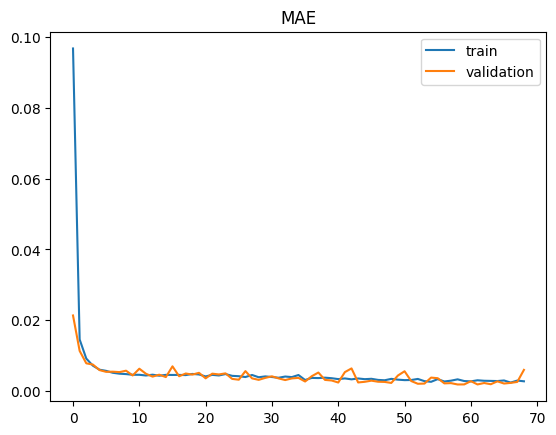

In [164]:
plt.title("MAE")
plt.plot(fited.history['mae'], label='train')
plt.plot(fited.history['val_mae'], label='validation')
plt.legend()
plt.show()

In [165]:
modelEmb.evaluate([x_test, y_test], test_morpho['slant'], return_dict=True)

313/313 [==============================] - 0s 1ms/step - loss: 1.8862e-05 - mae: 0.0019 - mse: 1.8862e-05


{'loss': 1.8862367141991854e-05,
 'mae': 0.001851430512033403,
 'mse': 1.8862367141991854e-05}

Contrario a lo esperado, la inserción del label empeora la métrica MAE

### Gráfico de embeddings

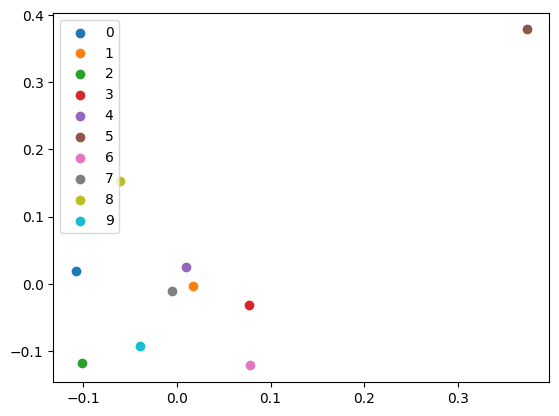

In [166]:
embWights = modelEmb.get_layer('Embedding').get_weights()[0]
for i, (x, y) in enumerate(embWights):
    plt.scatter(x, y, label=i)
plt.legend()
plt.show()

Se puede ver como algunos numeros tienden a esta más cerca, por algún significado que le haya dado el modelo al mismo. En particcular, el número 5 se ve muy alejado del resto.

## c. Con otra variable continua

Se elige utilizar la variable height, que como se vio en el EDA, era la que parecía más correlacionada al slant

In [183]:
def build_MNIST_modelCont(hp):

    inputImg = keras.Input(shape=(28,28), name='Input_Img')
    inputCont = keras.Input(shape=(1,), name='Input_Cont')

    flat_img = keras.layers.Flatten(name='Flatten_img')(inputImg)
    flat_emb = keras.layers.Flatten(name='Flatten_Emb')(inputCont)

    units = hp.Choice('units', [64, 128, 256])
    activation = hp.Choice('activation', activations)
    
    x = keras.layers.Concatenate(axis=-1)([flat_img, flat_emb])
    
    for i in range(hp.Int("n_layers", min_value=1, max_value=5)):
        x = keras.layers.Dense(units=units, activation=activation,
                                     kernel_initializer=hp.Choice('initializer', initials),
                                     bias_initializer=keras.initializers.Zeros())(x)
    
    out = keras.layers.Dense(1)(x)

    model = keras.Model(inputs=[inputImg, inputCont], outputs=out)

    model.compile(
        optimizer=hp.Choice('optimizer', optimizers),
        loss=hp.Choice('loss', losses),
        metrics=metrics,
    )
    return model

In [184]:
modelCont = build_MNIST_modelCont(best_hp)
modelCont.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Img (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 Input_Cont (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Flatten_img (Flatten)          (None, 784)          0           ['Input_Img[0][0]']              
                                                                                                  
 Flatten_Emb (Flatten)          (None, 1)            0           ['Input_Cont[0][0]']             
                                                                                            

In [185]:
fited = modelCont.fit(x = [xTrain, morphoTrain['height']], y=morphoTrain['slant'], batch_size=256,
             epochs=200, validation_data=([xVal, morphoVal['height']], yVal), callbacks=[earlyCb])

Epoch 1/200
246/246 [==============================] - 1s 3ms/step - loss: 0.0670 - mae: 0.1537 - mse: 0.0670 - val_loss: 0.0030 - val_mae: 0.0318 - val_mse: 0.0030
Epoch 2/200
246/246 [==============================] - 1s 3ms/step - loss: 0.0015 - mae: 0.0207 - mse: 0.0015 - val_loss: 7.1236e-04 - val_mae: 0.0145 - val_mse: 7.1236e-04
Epoch 3/200
246/246 [==============================] - 1s 3ms/step - loss: 5.0302e-04 - mae: 0.0116 - mse: 5.0302e-04 - val_loss: 3.5035e-04 - val_mae: 0.0097 - val_mse: 3.5035e-04
Epoch 4/200
246/246 [==============================] - 1s 3ms/step - loss: 2.7638e-04 - mae: 0.0084 - mse: 2.7638e-04 - val_loss: 2.2377e-04 - val_mae: 0.0076 - val_mse: 2.2377e-04
Epoch 5/200
246/246 [==============================] - 1s 3ms/step - loss: 1.8527e-04 - mae: 0.0069 - mse: 1.8527e-04 - val_loss: 1.6370e-04 - val_mae: 0.0066 - val_mse: 1.6370e-04
Epoch 6/200
246/246 [==============================] - 1s 3ms/step - loss: 1.3752e-04 - mae: 0.0060 - mse: 1.3752e-04 -

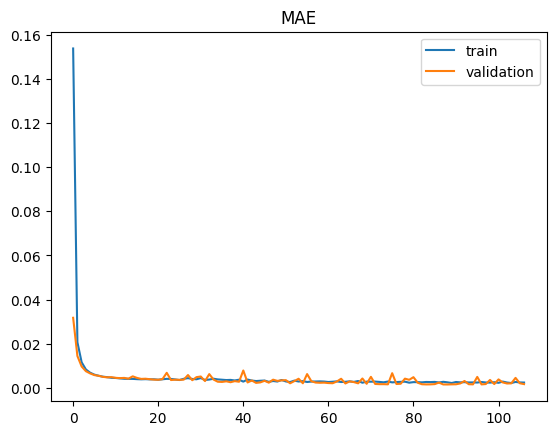

In [186]:
plt.title("MAE")
plt.plot(fited.history['mae'], label='train')
plt.plot(fited.history['val_mae'], label='validation')
plt.legend()
plt.show()

In [187]:
modelCont.evaluate([x_test, test_morpho['height']], test_morpho['slant'], return_dict=True)

313/313 [==============================] - 0s 1ms/step - loss: 1.6599e-05 - mae: 0.0016 - mse: 1.6599e-05


{'loss': 1.6599400623817928e-05,
 'mae': 0.001632668892852962,
 'mse': 1.6599400623817928e-05}

Tampoco se logra una mejora en la métrica